https://huggingface.co/datasets/vishnupriyavr/wiki-movie-plots-with-summaries

In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np

# Load the movie plots dataset
df_movies_plots = pd.read_csv(
    "hf://datasets/vishnupriyavr/wiki-movie-plots-with-summaries/wiki_movie_plots_deduped_with_summaries.csv"
)[['Title', 'PlotSummary']]
df_movies_plots.drop_duplicates(subset=['Title'], keep='last', inplace=True)
## Filter ratings dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
ratings_list = list(ratings)  # Will work for 100k dataset
ratings_dicts = [
    {
        "user_id": x["user_id"].numpy().decode("utf-8"),
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in ratings_list
]
ratings_df = pd.DataFrame(ratings_dicts)
ratings_df.movie_title = ratings_df.movie_title.map(lambda x: x.split('(')[0].strip())

ratings_df = pd.merge(ratings_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['user_id', 'movie_title']]
ratings_ds = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

## Filter movies dataset
movies = tfds.load("movielens/100k-movies", split="train")
movies_list = list(movies)  # Will work for 100k dataset
movies_dicts = [
    {
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in movies_list
]
movies_df = pd.DataFrame(movies_dicts)
movies_df.movie_title = movies_df.movie_title.map(lambda x: x.split('(')[0].strip())

movies_df = pd.merge(movies_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['movie_title']]
movies_ds = tf.data.Dataset.from_tensor_slices(dict(movies_df))


# Prepare the ratings dataset for training
ratings_ds = ratings_ds.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies_ds = movies_ds.map(lambda x: x["movie_title"])


# Shuffle and split the data
tf.random.set_seed(42)
shuffled = ratings_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(50_000) ## After filtering rating_ds has 67,921 rows
test = shuffled.skip(50_000).take(20_000)

# Prepare unique user and movie vocabularies
movie_titles = movies_ds.batch(1_000)
user_ids = ratings_ds.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))


/Users/Carole/projects/dpp-paper-demo/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow_recommenders as tfrs
from typing import Dict, Text

## Define the Two Tower model 
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies_ds.batch(128).map(movie_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class MovielensModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

In [3]:
## Train the model
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)

model.evaluate(cached_test, return_dict=True)

Epoch 1/3
7/7 [==============================] - 2s 239ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0095 - factorized_top_k/top_10_categorical_accuracy: 0.0217 - factorized_top_k/top_50_categorical_accuracy: 0.1127 - factorized_top_k/top_100_categorical_accuracy: 0.1997 - loss: 56694.5352 - regularization_loss: 0.0000e+00 - total_loss: 56694.5352
Epoch 2/3
7/7 [==============================] - 2s 237ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_accuracy: 0.0309 - factorized_top_k/top_10_categorical_accuracy: 0.0615 - factorized_top_k/top_50_categorical_accuracy: 0.2477 - factorized_top_k/top_100_categorical_accuracy: 0.4022 - loss: 55081.3110 - regularization_loss: 0.0000e+00 - total_loss: 55081.3110
Epoch 3/3
5/5 [==============================] - 1s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0132 

{'factorized_top_k/top_1_categorical_accuracy': 0.0020088164601475,
 'factorized_top_k/top_5_categorical_accuracy': 0.013168907724320889,
 'factorized_top_k/top_10_categorical_accuracy': 0.029741642996668816,
 'factorized_top_k/top_50_categorical_accuracy': 0.1745438277721405,
 'factorized_top_k/top_100_categorical_accuracy': 0.3276044726371765,
 'loss': 10769.1494140625,
 'regularization_loss': 0,
 'total_loss': 10769.1494140625}

In [4]:
## make predictions 
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies_ds.batch(100), movies_ds.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Just Cause' b'Maverick' b'Sleepless in Seattle']


In [5]:
import lancedb

# Create movies_docs
movies_list = movie_model.layers[0].get_vocabulary()
movies_weights = movie_model.layers[1].get_weights()[0].astype(np.float32)
movie_data = [
    {"movie_name": name, "vector": embedding}
    for name, embedding in zip(movies_list, movies_weights)
]
# Create or open a local LanceDB
db = lancedb.connect("./tmp/lancedb")

# Create a table from the movie data
movies_table = db.create_table("movies", data=movie_data, mode="overwrite")

users_list = user_model.layers[0].get_vocabulary()
users_weights = user_model.layers[1].get_weights()[0].astype(np.float32)
user_embedding_dict = {x: y for x, y in zip(users_list, users_weights)}

user_id = users_list[0]
user_vector = user_embedding_dict[user_id]

# Search for top 100 most similar movies using cosine similarity
results = movies_table.search(user_vector).metric("cosine").limit(100).to_pandas()

# The results will include a `_distance` column (cosine distance = 1 - cosine similarity)
results["cosine_similarity"] = 1 - results["_distance"]


[2025-07-16T12:27:40Z WARN  lance::dataset::write::insert] No existing dataset at /Users/Carole/projects/dpp-paper-demo/tmp/lancedb/movies.lance, it will be created


In [6]:
results = results.merge(df_movies_plots, left_on='movie_name', right_on='Title', how='inner')
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
results['plot_semantic_embedding'] = results['PlotSummary'].apply(lambda x: model.encode(x, convert_to_numpy=True))


In [7]:
results

,movie_name,vector,_distance,cosine_similarity,Title,PlotSummary,plot_semantic_embedding
0,Absolute Power,"[-0.35636294, -0.23188958, 0.105036445, -0.160...",0.589504,0.410496,Absolute Power,Master jewel thief Luther Whitney (Clint Eastw...,"[-0.08252412, -0.02723278, -0.022185367, -0.00..."
1,Mortal Kombat: Annihilation,"[-0.15911835, 0.1301726, 0.19562957, 0.2308108...",0.609168,0.390832,Mortal Kombat: Annihilation,Earthrealm (Earth) is in danger of being absor...,"[0.058898874, 0.018678179, -0.0181642, -0.0276..."
2,Richard III,"[-0.12868161, -0.28963217, -0.16613238, 0.0815...",0.633558,0.366442,Richard III,"In late 1930s England, a chaotic and bloody ci...","[-0.052544322, 0.05399895, 0.03471127, -0.0479..."
3,2 Days in the Valley,"[-0.20185843, -0.6404002, -0.06711448, -0.3161...",0.645787,0.354213,2 Days in the Valley,Hitmen Lee Woods and Dosmo Pizzo kill Becky Fo...,"[-0.041404866, -0.0018621123, -0.019204864, 0...."
4,Coldblooded,"[-0.10939438, -0.0859862, -0.0691329, -0.04393...",0.657516,0.342484,Coldblooded,Cosmo Reif is a mob bookie who lives in the ba...,"[0.0032122014, -0.08078399, -0.06052808, -0.00..."
...,...,...,...,...,...,...,...
94,Trees Lounge,"[-0.18511268, -0.39198473, 0.20817548, 0.01386...",0.809848,0.190152,Trees Lounge,Tommy Basilio is an alcoholic and fixture at a...,"[-0.0630115, 0.03760949, 0.0055633956, -0.0133..."
95,Men in Black,"[-0.07707693, 0.1110092, 0.020030573, -0.18440...",0.810021,0.189979,Men in Black,Men in Black is a secret agency that protects ...,"[-0.03869044, 0.028567279, -0.08433635, 0.0511..."
96,Angel Baby,"[0.22197388, -0.077402696, 0.22586447, -0.1562...",0.812788,0.187212,Angel Baby,Harry (Lynch) and Kate (McKenzie) meet during ...,"[-0.006121311, -0.040593408, -0.011059789, 0.0..."
97,Shadow Conspiracy,"[-0.48053524, -0.32525977, 0.31895986, -0.2504...",0.814856,0.185144,Shadow Conspiracy,"Set in Washington, this film documents an atte...","[-0.13942198, -0.009533701, -0.08396972, -0.06..."


In [8]:
from dppy.finite_dpps import FiniteDPP
from typing import List

class DiversificationPipeline:
    def __init__(self, item_semantic_embeddings: List, ids: List, scores: List) -> None:
        self.item_semantic_embeddings = np.array(
            item_semantic_embeddings, dtype=np.float64
        )
        self.item_ids = ids
        self.scores = np.array(scores, dtype=np.float64) ## scores are relevance qi score from TT

    @staticmethod
    def _get_dpp_samples(vectors: np.ndarray, K_DPP: int) -> List:
        diversification_matrix = vectors.dot(vectors.T)
        dpp_model = FiniteDPP("likelihood", **{"L": diversification_matrix})
        return dpp_model.sample_exact_k_dpp(size=K_DPP)

    def get_sampled_ids(self, K_DPP: int, use_qi: bool) -> List:
        # Calculate weighted embeddings and normalize in a single step
        weighted_embeddings = (
            self.scores[:, np.newaxis] * self.item_semantic_embeddings
            if use_qi
            else self.item_semantic_embeddings
        )

        # Apply DPP sampling
        sampled_indices = self._get_dpp_samples(
            vectors=weighted_embeddings, K_DPP=K_DPP
        )

        return [self.item_ids[i] for i in sampled_indices]
    
 

In [9]:
output_size = 5
use_qi = True
retrieved_movies = results[['movie_name', 'cosine_similarity', 'plot_semantic_embedding']].to_dict(orient='records')
diversified_movies = DiversificationPipeline(
    item_semantic_embeddings=[
        item["plot_semantic_embedding"] for item in retrieved_movies
    ],
    ids=[item["movie_name"] for item in retrieved_movies],
    scores=[float(item["cosine_similarity"]) for item in retrieved_movies],
).get_sampled_ids(K_DPP=output_size, use_qi=use_qi)

top_movies = results.movie_name.to_list()[:5]



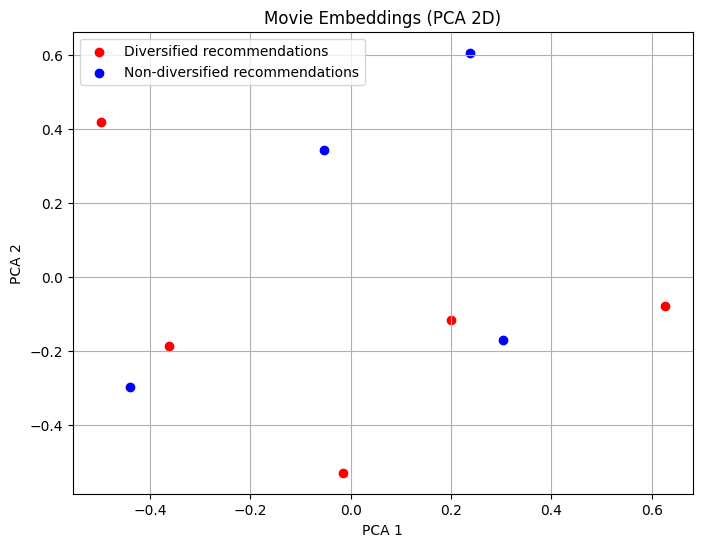

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Merge all unique movies from both lists
all_movies = list(set(top_movies + diversified_movies))
X = np.array(results[results.movie_name.isin(all_movies)]['plot_semantic_embedding'].to_list())

# PCA to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))

# Track plotted labels for deduplicating legend
plotted_labels = set()

for i, movie in enumerate(all_movies):
    if movie in diversified_movies:
        label = "Diversified recommendations" if "Diversified recommendations" not in plotted_labels else None
        plt.scatter(X_2d[i, 0], X_2d[i, 1], color='red', label=label)
        plotted_labels.add("Diversified recommendations")
    elif movie in top_movies:
        label = "Non-diversified recommendations" if "Non-diversified recommendations" not in plotted_labels else None
        plt.scatter(X_2d[i, 0], X_2d[i, 1], color='blue', label=label)
        plotted_labels.add("Non-diversified recommendations")

plt.title("Movie Embeddings (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()
